In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 100
TRAIN_SIZE  = 0.7
NOISE       = 0.0
MESH_SIZE   = 100

POPSIZE         = 100
MAX_STREE_DEPTH = 5
GENERATIONS     = 25
GROUP_SIZE      = 5  # tournament selector.
MUTATION_RATE   = 0.15
ELITISM         = 1

LIBSIZE      = 2000
LIB_MAXDEPTH = 3

RANDSTATE = 123

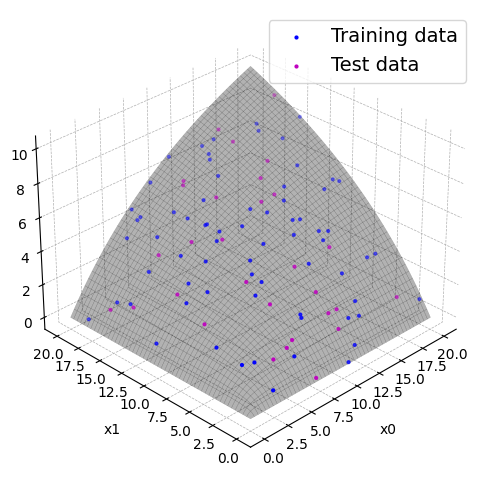

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

solutionCreator = gp_creator.RandomSolutionCreator(nvars=S.nvars)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

X_mesh         = S_train.spsampler.meshspace(S_train.xl, S_train.xu, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, X_mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, X_mesh, LIBSIZE, LIB_MAXDEPTH)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")

  0%|          | 0/24 [00:00<?, ?it/s]

         4254957 function calls (4100060 primitive calls) in 13.167 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2400    0.054    0.000   13.164    0.005 corrector.py:21(correct)
     2375    0.085    0.000   11.555    0.005 library.py:302(cquery)
     2375    0.462    0.000    8.906    0.004 library.py:329(__get_matching_libs)
   436350    1.785    0.000    8.441    0.000 constraints.py:35(match_key)
   433032    0.734    0.000    6.656    0.000 <__array_function__ internals>:177(array_equal)
   433032    3.823    0.000    5.824    0.000 numeric.py:2407(array_equal)
    38604    0.046    0.000    2.476    0.000 library.py:76(query)
    38604    1.186    0.000    2.430    0.000 _kdtree.py:363(query)
   855432    2.011    0.000    2.011    0.000 _methods.py:61(_all)
     2400    0.037    0.000    1.104    0.000 corrector.py:60(backprop_know)
    77208    0.202    0.000    0.684    0.000 <__array_function__ internal

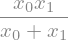

In [5]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

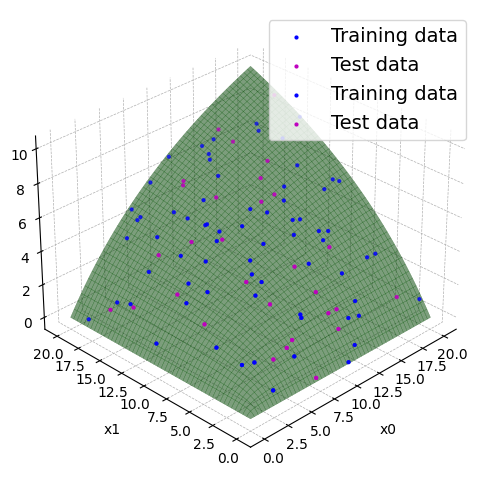

In [6]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)

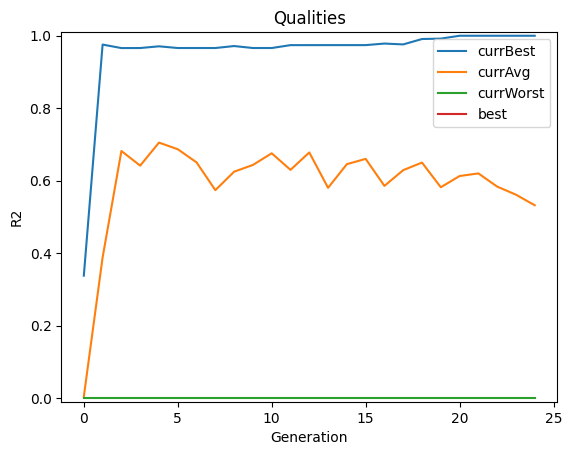

In [7]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

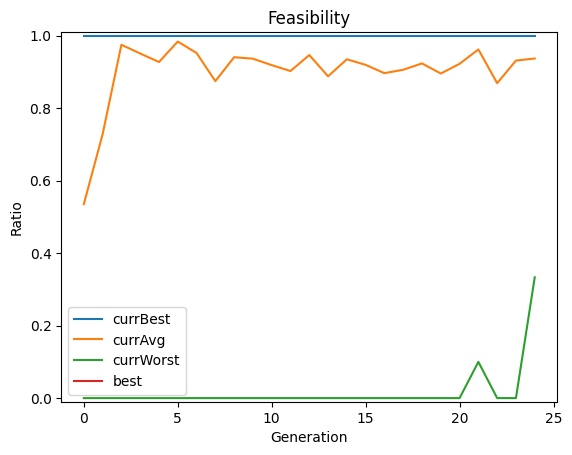

In [8]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

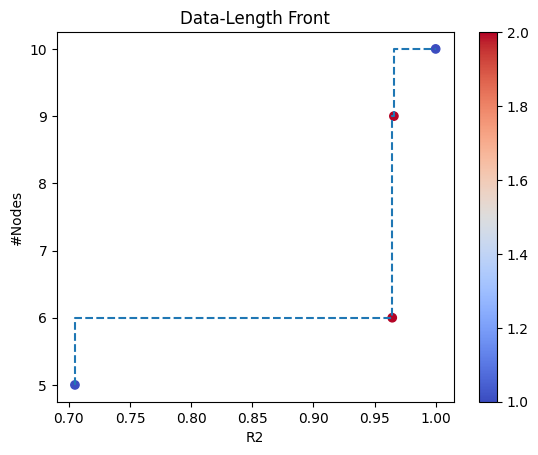

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,((x0 + x1) * 0.24),0,0.140996,0.704980,5,(+),1,inf
1,1,(((x0 / x1) / (x0 + x1)) * square(x1)),0,0.100000,1.000000,10,"(+, /, square, *)",1,inf
2,2,sqrt((x1 * (0.22 * x0))),0,0.160749,0.964493,6,"(sqrt, *)",2,1.684200
3,3,sqrt(((x1 * 0.24) * (x0 * sqrt(0.88)))),0,0.107315,0.965837,9,"(sqrt, *)",2,0.920356
4,0,((x0 * 0.05) * x1),1,0.026437,0.132183,5,(*),1,inf
5,1,((x1 / (x0 + x1)) * (x1 * exp(log((x0 / x1))))),1,0.076923,1.000000,13,"(+, *, exp, /, log)",1,inf
6,2,sqrt((0.24 * (x0 * x1))),1,0.160472,0.962829,6,"(sqrt, *)",2,1.334016
7,3,sqrt((square(-0.52) * (exp(-0.18) * (x1 * x0)))),1,0.096584,0.965837,10,"(square, exp, sqrt, *)",1,0.540510
8,4,sqrt(((x0 * 0.34) * (x1 * 0.64))),1,0.120554,0.964433,8,"(sqrt, *)",2,0.377323
9,5,sqrt((((x1 * 0.41) / exp(0.64)) * x0)),1,0.107205,0.964845,9,"(/, exp, sqrt, *)",1,0.251617


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data/length, data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)